# <b>Phase 4: Data Modeling</b>

##### <b>Objectives:</b> 
- Build a model that can predict a song's popularity based on the song's key features. Therefore, we can decide whether a song is a hit based on the score prediction.
- Build a recommendation system that can suggest songs based on user's input choices such as: genre, year, 

### <b><u>Step 1</u>: Import library</b>

##### These are the main libraries used for data modeling:

- `numpy`: work with arrays and some helper functions for modeling
- `pandas`: used to store data as a DataFrame
- `matplotlib`: used to visualize data
- `sklearn`: used train_test_split to split the dataset, KFold to build a cross validation pipeline, LinearRegression and KMeans to build models and metrics to measure the model's accuracy.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression as lr
from sklearn.cluster import KMeans
from sklearn import metrics

### <b><u>Step 2</u>: Get the songs DataFrame from songs exploration notebook to build models</b>

At this step, we need to import the `songs_model_df` from the songs exploration notebook to split data and build models.

In [2]:
%store -r songs_model_df

### <b><u>Step 3</u>: Split the data into training set and test set</b>

Now that we have the songs DataFrame, we would like to split the data into training set and test set, with 80% of training set and 20% of test set using `train_test_split` function.

And then the split data will be stored in 4 variables: `train_features`, `test_features`, `train_label` and `test_label`

In [3]:
model_df = songs_model_df

train_features, test_features, train_label, test_label = train_test_split(model_df.iloc[:, :-1], model_df.iloc[:, -1], test_size = 0.2, shuffle=True)

Let's re-check the variables' shape

In [4]:
train_features.shape, train_label.shape, test_features.shape, test_label.shape

((2400, 6), (2400,), (600, 6), (600,))

So the shapes of these variables are proportionally correct.

Now, let's visualize the songs data to have an overview look.

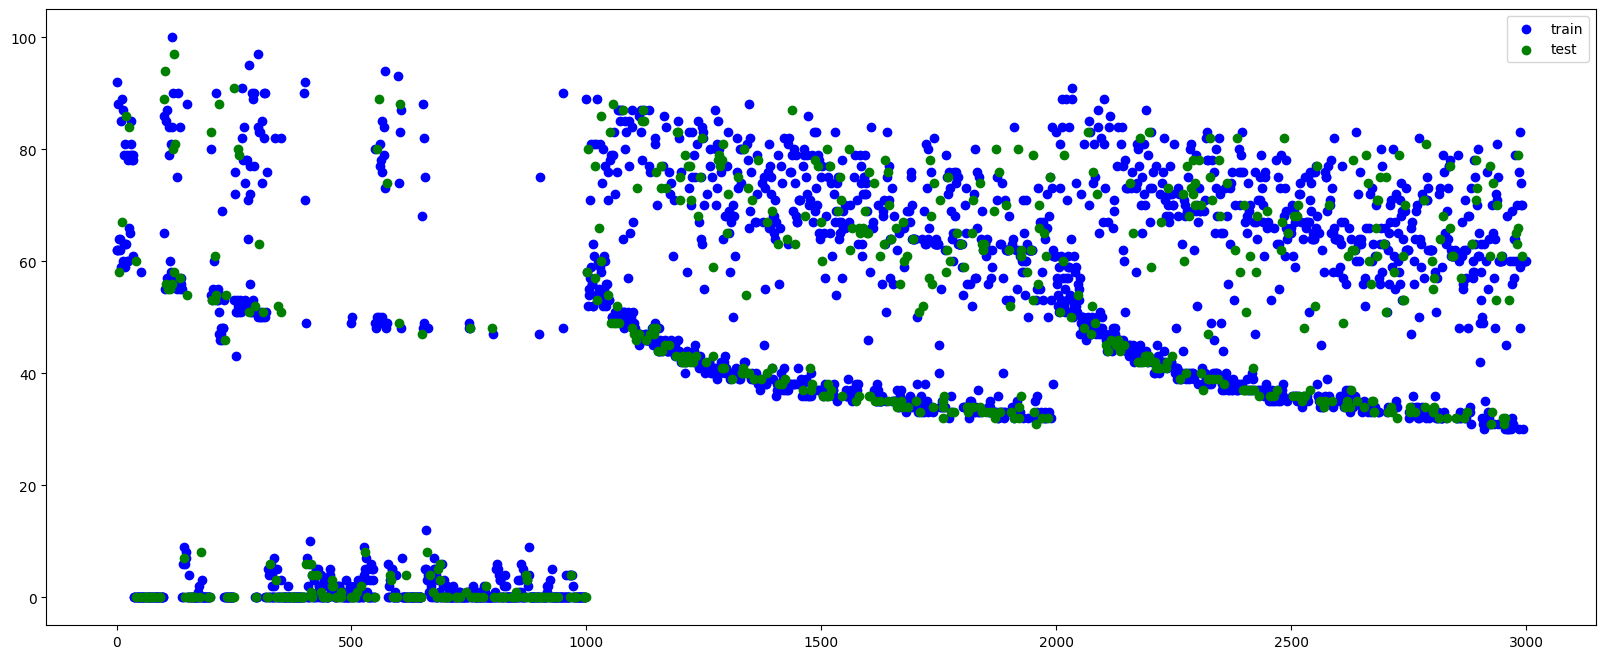

In [5]:
plt.figure(figsize=(20, 8))
plt.scatter(train_label.index, train_label.values, color='b', label='train')
plt.scatter(test_label.index, test_label.values, color='g', label='test')
plt.legend()

So the data is now splitted into training set and test set, with the test set randomly chosen.

### <b><u>Step 3</u>: Generate Linear Regression model with no bias and RMSE function</b>

At this step, we would like to build our own Linear Regression model with no bias to compare between either model with or without bias will perform better.

Furthermore, there will be a function to calculate the RMSE between the model prediction and the test set.

In [6]:
class LinearRegression:
    def fit(self, X, y):
        X_pinv = np.linalg.inv(X.T @ X) @ X.T
        self.w = X_pinv @ y
        return self

    def get_weight(self):
        return self.w

    def predict(self, X):
        return np.sum(self.w.ravel() * X, axis=1)

def model_rmse(y_test, y_pred):
    return np.sqrt(np.mean((y_test.ravel() - y_pred.ravel())**2))

### <b><u>Step 4</u>: Train and predict data with no-biased model</b>

Now, we will fit the whole training data into the model and then predict the test data.

In [7]:
model1 = LinearRegression().fit(train_features, train_label)

After we fit the train features and train label set into the model, now let's predict the songs' popularity of the test features set.

Since we would like to have a floor popularity score of 0, any value that is smaller than 0 will be set to 0. Finally, print the model RMSE and visualize the data.

In [27]:
y_pred = model1.predict(test_features)
result1 = pd.DataFrame(y_pred, columns=['popularity'], index=test_features.index)
result1[result1['popularity'] < 0] = 0
print('MSE of biased model:', metrics.mean_squared_error(test_label, y_pred))
print('RMSE of biased model:', model_rmse(test_label, y_pred))
print('MAE of biased model:', metrics.mean_absolute_error(test_label, y_pred))

MSE of biased model: 28.606914293750286
RMSE of biased model: 5.348543193594896
MAE of biased model: 4.181959371616676


The model basically performed pretty well with MSE less than 30, RMSE from 5.0 to 6.0 and MAE around 4.5

Now let's plot the whole train data, test data and predict data to have an overview look on how the model performed.

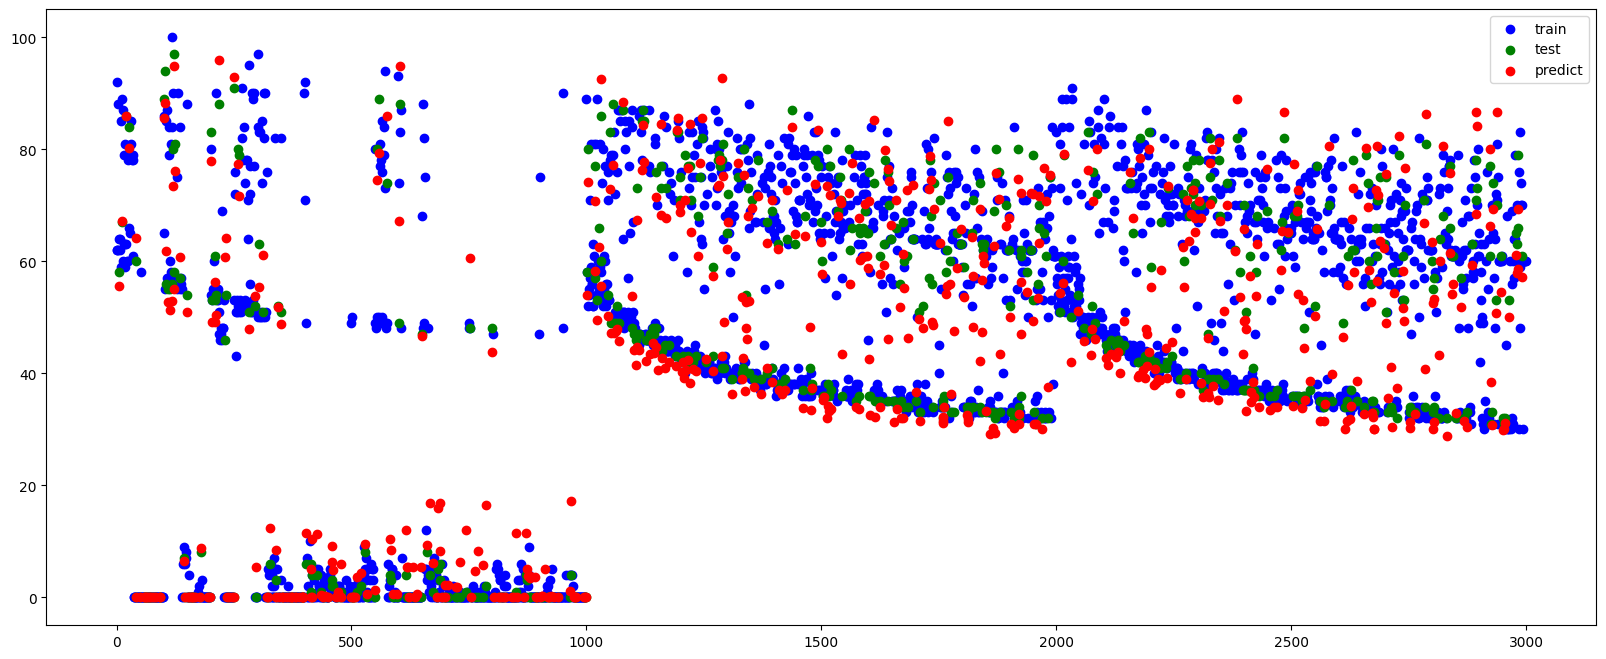

In [9]:
plt.figure(figsize=(20, 8))
plt.scatter(train_label.index, train_label.values, color='b', label='train')
plt.scatter(test_label.index, test_label.values, color='g', label='test')
plt.scatter(result1['popularity'].index, result1['popularity'].values, color='r', label='predict')
plt.legend()

### <b><u>Step 5</u>: Train and predict data with biased model</b>

After we saw how the no-biased model performed, it's time to move on the biased-model using LinearRegression built-in model from sklearn to fit, predict and then check its RMSE score and accuracy score.

In [25]:
model2 = lr().fit(train_features, train_label)
pred = model2.predict(test_features)
result2 = pd.DataFrame(pred, columns=['popularity'], index=test_features.index)
result2[result2['popularity'] < 0] = 0
print('MSE of biased model:', metrics.mean_squared_error(test_label, pred))
print('RMSE of biased model:', model_rmse(test_label, pred))
print('MAE of biased model:', metrics.mean_absolute_error(test_label, pred))
print('Model score:', model2.score(test_features, test_label))

MSE of biased model: 26.825384735644185
RMSE of biased model: 5.179322806665383
MAE of biased model: 3.7475424390383605
Model score: 0.964221736196754


We can see clearly that the biased model worked better than the no-biased one, also the score of model itself is pretty high (> 85%). Therefore, this model can be used to predict a song's popularity score and decide whether a song is a hit or not.

Finally, let's plot the train data, test data and the predict data to have an overview look.

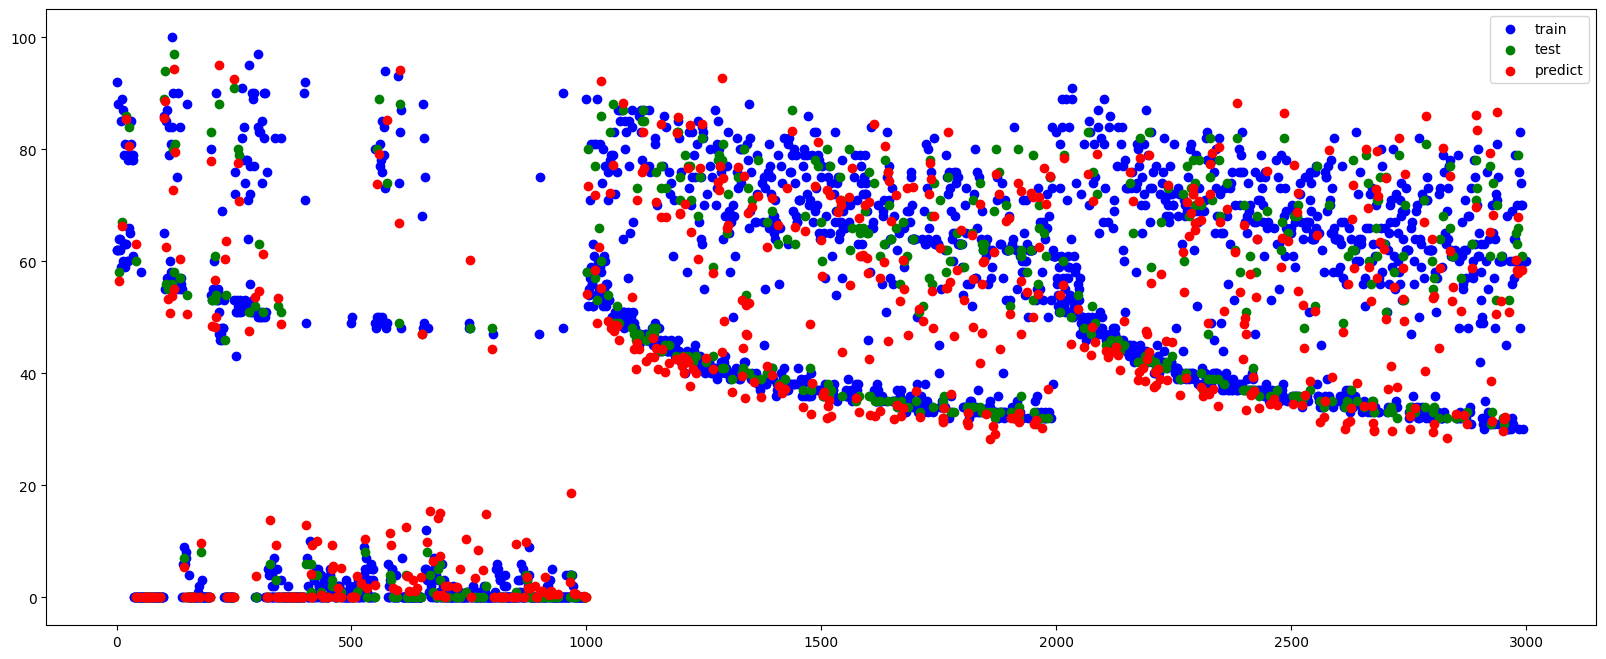

In [11]:
plt.figure(figsize=(20, 8))
plt.scatter(train_label.index, train_label.values, color='b', label='train')
plt.scatter(test_label.index, test_label.values, color='g', label='test')
plt.scatter(result2['popularity'].index, result2['popularity'].values, color='r', label='predict')
plt.legend()

### <b><u>Step 4</u>: Final the most impactful feature of the model</b>

Finally, we would like to know which feature has the most impact in the model, aka the importance variable of the model. 

To verify, we will use the `K-Fold cross validation` method, splitting the data into 5 equal parts and train + test each feature one at a time to find its best model and compare the RMSE to find out which feature performs best.

In [29]:
def train_each_feature_cross_validation(train, fold = 5):
    feature = {k: 0 for k in train.columns if k != 'popularity'}

    for train_split, test_split in KFold(n_splits=fold, shuffle=True).split(train):
        for column in feature.keys():
            feature_train = np.array(train.iloc[train_split].loc[:,[column]])
            label_train = np.array(train.iloc[train_split].loc[:,['popularity']])

            feature_test = np.array(train.iloc[test_split].loc[:,[column]])
            label_test = np.array(train.iloc[test_split].loc[:,['popularity']])
                
            model = LinearRegression().fit(feature_train, label_train)
            pred = model.predict(feature_test)
            rmse = model_rmse(label_test, pred)

            feature[column] += rmse

    return {k: v/fold for k, v in feature.items()}

Now, let's run the function and choose the best feature with the smallest RMSE from its best model.

In [30]:
features = train_each_feature_cross_validation(pd.concat([train_features, train_label], axis=1))
best_feature = min(features, key=features.get)
print('The best feature in the dataset (most correlated feature to label):', best_feature)

The best feature in the dataset (most correlated feature to label): album_popularity


As we expected from the exploration phase and analysis phase, `album_popularity` is the most correlated feature to `popularity` feature, meaning that it is the most impactful feature that helps the model to predict a song's popularity score.

Finally, let's plot the data based on the `album_popularity` and `popularity` features to see how much they are correlated.

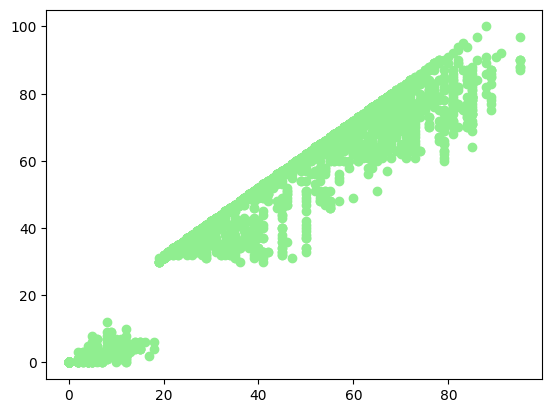

In [36]:
plt.scatter(model_df.loc[:, 'album_popularity'], model_df.loc[:, 'popularity'], color='lightgreen')
plt.show()

----
### <b> This is the end of Phase 4</b>